In [104]:
import logging, os
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import tensorflow as tf
keras = tf.keras
layers = keras.layers
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt

from functools import wraps
import time

In [115]:
def show_2_images(src, dst):
    src = (np.array(src) * 255).astype(np.uint8)
    dst = (np.array(dst) * 255).astype(np.uint8)
    
    if len(src.shape) == 4: src = src.squeeze(0)
    if len(dst.shape) == 4: dst = dst.squeeze(0)
    
    plt.figure(figsize=(8, 4))
    
    plt.subplot(1, 2, 1)
    plt.imshow(src)
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(dst)
    plt.axis('off')
    
    plt.show()
    return


def load_img_and_resize(paths, k=2, even_shape=True):
    def update_shape_to_even(img):
        shape = list(img.size)
        if shape[0] % k or shape[1] % k:
            if shape[0] % k: shape[0] = (shape[0] // k) * k
            if shape[1] % k: shape[1] = (shape[1] // k) * k
            return img.resize((shape[0], shape[1]), Image.ANTIALIAS)
        return img

    if isinstance(paths, list):
        imgs_np = []
        resized_np = []
        for filename in paths:
            img = Image.open(filename).convert('RGB')
            if even_shape: img = update_shape_to_even(img)
            img_np = (np.expand_dims(np.array(img), axis=0) / 255.).astype(np.float32)
            resized = np.expand_dims(np.array(img.resize([size // k for size in img.size], Image.ANTIALIAS)) / 255.,
                                     axis=0).astype(np.float32)
            imgs_np += [img_np]
            resized_np += [resized]
        return imgs_np, resized_np

    elif isinstance(paths, str):
        img = Image.open(paths).convert('RGB')
        if even_shape: img = update_shape_to_even(img)
        img_np = (np.expand_dims(np.array(img), axis=0) / 255.).astype(np.float32)
        resized = np.expand_dims(np.array(img.resize([size // k for size in img.size], Image.ANTIALIAS)) / 255.,
                                 axis=0).astype(np.float32)
        return img_np, resized

    else:
        raise "not correct paths"


# Декоратор для проверки времени работы функции
def timer(func):

    @wraps(func)
    def wrapper(*args, **kwargs):
        t = time.time()
        func(*args, **kwargs)
        print(time.time() - t)
    return wrapper

In [116]:
def init_fmodel():
    model = keras.Sequential([])
    model.add(layers.Conv2D(16, 3, 1, padding='same', activation='relu'))
    model.add(layers.UpSampling2D(2))
    model.add(layers.Conv2D(16, 3, 1, padding='same', activation='relu'))
    model.add(layers.UpSampling2D(2))
    model.add(layers.Conv2D(16, 3, 1, padding='same', activation='relu'))
    model.add(layers.Conv2D(3, 3, 1, padding='same', activation='relu'))
    return model

In [117]:
len(os.listdir('../images/train2014/'))

82783

In [118]:
filenames = ['../images/train2014/' + name for name in os.listdir('../images/train2014/')]

### Version 1

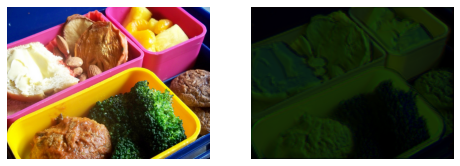

Step - 0;	 Loss - 0.399;	 Time spent - 4.1
Step - 1;	 Loss - 0.330;	 Time spent - 3.2
Step - 2;	 Loss - 0.249;	 Time spent - 3.2
Step - 3;	 Loss - 0.195;	 Time spent - 3.2
Step - 4;	 Loss - 0.145;	 Time spent - 3.2
Step - 5;	 Loss - 0.111;	 Time spent - 3.3
Step - 6;	 Loss - 0.104;	 Time spent - 3.2
Step - 7;	 Loss - 0.100;	 Time spent - 3.2
Step - 8;	 Loss - 0.096;	 Time spent - 3.2
Step - 9;	 Loss - 0.093;	 Time spent - 3.2
Step - 10;	 Loss - 0.090;	 Time spent - 3.2
Step - 11;	 Loss - 0.086;	 Time spent - 3.2
Step - 12;	 Loss - 0.084;	 Time spent - 3.2
Step - 13;	 Loss - 0.081;	 Time spent - 3.2
Step - 14;	 Loss - 0.079;	 Time spent - 3.2
Step - 15;	 Loss - 0.078;	 Time spent - 3.2
Step - 16;	 Loss - 0.076;	 Time spent - 3.2
Step - 17;	 Loss - 0.074;	 Time spent - 3.2
Step - 18;	 Loss - 0.073;	 Time spent - 3.2
Step - 19;	 Loss - 0.072;	 Time spent - 3.2


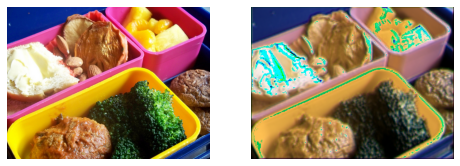

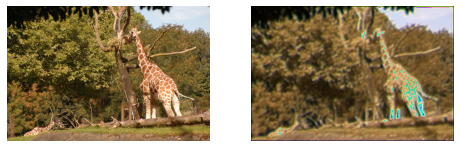

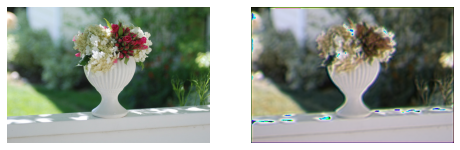

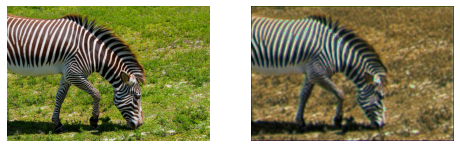

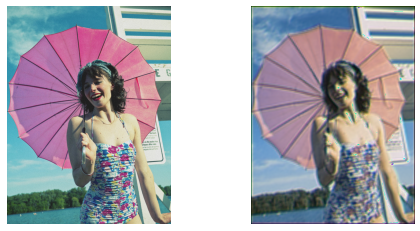

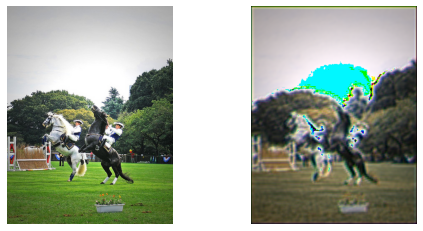

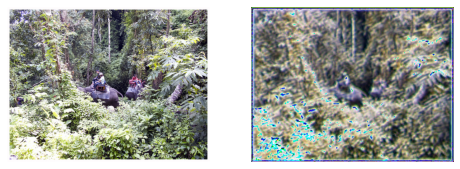

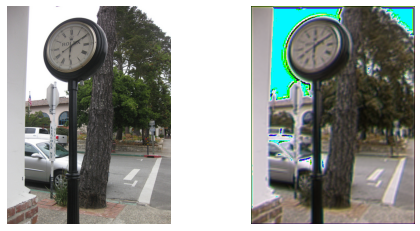

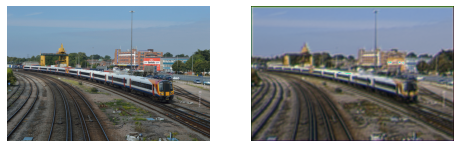

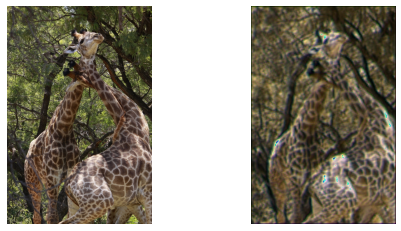

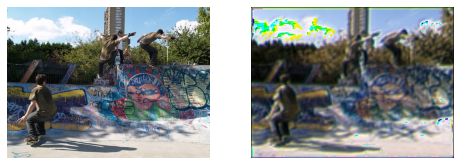

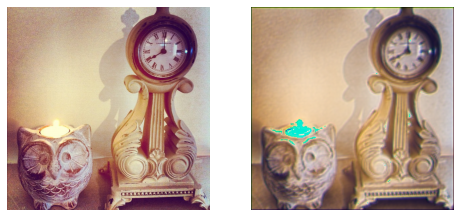

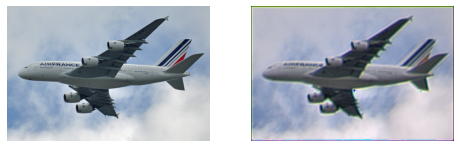

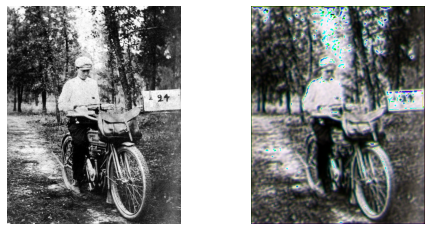

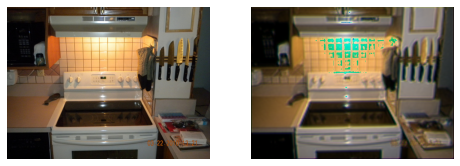

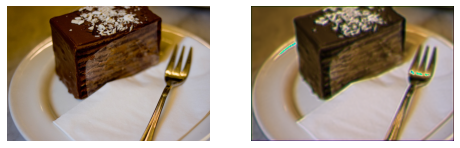

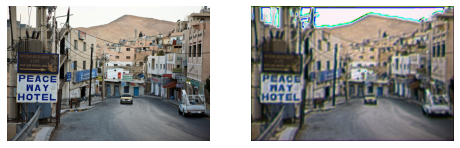

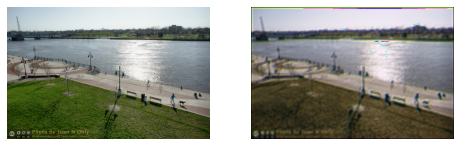

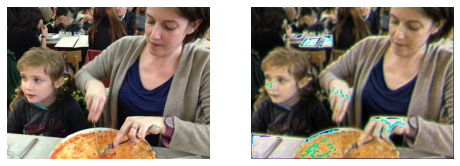

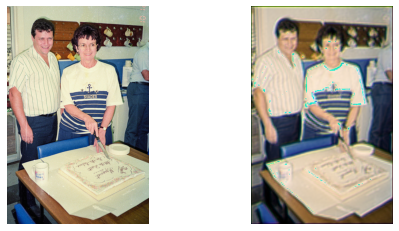

In [120]:
@tf.function
def grad(model, inputs, targets, loss):
    with tf.GradientTape() as g:
        g_loss = loss(targets, model(inputs))
        grads = g.gradient(g_loss, model.trainable_variables)
    return g_loss, grads


optimizer_obj = tf.keras.optimizers.Adam(learning_rate=0.0001)
# loss_obj = lambda x, y: tf.math.reduce_mean(tf.math.abs(tf.math.subtract(x, y)))
@tf.function
def loss_obj(x, y):
    return tf.math.reduce_mean(tf.math.abs(tf.math.subtract(x, y)))

model = init_fmodel()
steps = 20


filenames = filenames[:20]


for filename in filenames:
    src_img, resized = load_img_and_resize(filename, 4)
    pred = model(resized)
    show_2_images(src_img, pred)
    break


step_loss = []

for step in range(steps):
    sum_loss = []
    startTime = time.time()
    for filename in filenames:
        src_img, resized = load_img_and_resize(filename, 4)
        g_loss, grads = grad(model, resized, src_img, loss_obj)
        optimizer_obj.apply_gradients(zip(grads, model.trainable_variables))
        sum_loss += [g_loss]
    step_loss += [np.mean(sum_loss)]
    print(f'Step - {step};\t Loss - {step_loss[-1]:.3f};\t Time spent - {time.time() - startTime:.1f}')


for filename in filenames:
    src_img, resized = load_img_and_resize(filename, 4)
    pred = model(resized)
    show_2_images(src_img, pred)

### Version 2